#### `gp.Marginal`

Commonly, a function is observed with additive Gaussian noise.  Since multivariate normals are self-conjugate, we can marginalize out the latent function $f(x)$.  Calling the `marginal_likelihood` method creates a PyMC3 random variable that represents 
  $$
    p(y \mid x) = \int p(y \mid f) \, p(f \mid X) df  \,.
  $$ 
  Calling `conditional` produces $\mathbf{f_*}$ (or optionally $\mathbf{y}_*)$, which includes the Gaussian noise).  Since $f(x)$ has been marginalized out, a `prior` method doesn't make sense and is not implemented for `gp.Marginal`.  
  
Similarly to `gp.Latent`, a marginal GP is specified by
  
    gp = pm.gp.Marginal(mean_func, cov_func)
  
  The marginal likelihood, $p(y \mid X)$ is 
  
    ym = gp.marginal_likelihood("ym", n_points, X, y, noise)
    
  the conditional distribution is
  
    f_pred = gp.conditional("f_pred", n_pred, X_new)
  
  
Any number of `gp.*` objects can also be added together using the `+` operator, i.e., `gp3 = gp1 + gp2` (the sum of two GPs is also a GP).  This allows the users to construct composite GP priors for functions that are themselves sums of functions.  Consider the function $f(x_1, x_2) = g(x_1) + h(x_2)$.  By placing GP priors on $g(x_1)$ and $h(x_2)$, we can separate the effects due to $x_1$ and $x_2$ on $f$.

# Example: `gp.Marginal`

There is a more efficient way to model the last example.  Most GP introductions or tutorials describe the scenario we just covered -- regression with IID Gaussian noise.  This is the most common GP model that people use, but it's really a special case.  When the noise is Gaussian there is no need to explicitly include $\mathbf{f}_x$ as latent variables because it can be integrated out analytically.  

As mentioned before, the product of the GP prior probability distribution with a normal likelihood is also normal.  It's called the *marginal likelihood*.  If we including the prior on the hyperparameters of the covariance function, we can write the *marginal posterior* as

$$
p(y \mid x, \theta)p(\theta) = \int p(y \mid f, x, \theta) \, p(f \mid x, \theta) \,
                                    p(\theta) df
$$

Taking the log,

$$
\log p(y \mid x, \theta) \, p(\theta) = 
  -\frac{1}{2} \mathbf{y}^{T} (K_{xx} + \sigma^2 I)^{-1} \mathbf{y}
  - \frac{1}{2}|K_{xx} + \sigma^2 I|
  - \frac{n}{2}\log (2 \pi) + \log p(\theta)
$$

The first term penalizes lack of fit, the second term penalizes model complexity via the determinant of $K_{xx}$.  The third term is just a constant.  The final term on the right is the log-prior of the covariance function hyperparameters.    

The code to specify this equivalent model using `gp.Marginal` is a little bit different that before.  The `gp.marginal_likelihood` subsumes both the GP prior and the Normal likelihood of the observed data, `y`.  Also, since we are using the marginal likelihood, it is possible to use `find_MAP` to quickly get the value at the mode of the covariance function hyperparameters.  

In [8]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

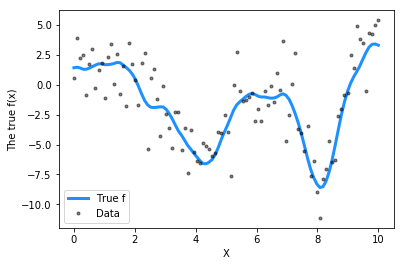

In [9]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
plt.xlabel("X"); plt.ylabel("The true f(x)"); plt.legend();

In [10]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
     
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", n_points=n, X=X, y=y, noise=σ)
    
    mp = pm.find_MAP()#method="L-BFGS-B")

lp = -229.66, ||grad|| = 0.0013279:   0%|          | 99/50000 [00:00<06:33, 126.76it/s]


In [11]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"], 
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

,Parameter,True value,Value at MAP
0,ℓ,1.0,1.109897
1,η,3.0,3.911457
2,σ,2.0,1.916388


In [3]:
# new values from x=0 to x=20
n_new = 500
X_new = np.linspace(0, 20, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", n_new, X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)

NameError: name 'model' is not defined

In [4]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp(ax, X_new.flatten(), pred_samples["f_pred"].T);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)"); plt.ylim([-13,13]); 
plt.title("Conditional distribution of f_*, given f and theta"); plt.legend();

NameError: name 'plot_gp' is not defined

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [5]:
with model:
    y_pred = gp.conditional("y_pred", n_new, X_new, pred_noise=True)
    y_samples = pm.sample_ppc([mp], vars=[y_pred], samples=1000)

NameError: name 'model' is not defined

In [6]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp(ax, X_new.flatten(), y_samples["y_pred"].T, False, "bone_r");

"""INSTEAD PLOT 1 SAMPLE FROM PP DIST AS DOTS"""
# overlay a scatter of random points from the posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][12, :].T, "co", ms=2);

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");

plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior predictive distribution, y_*"); plt.legend();

NameError: name 'plot_gp' is not defined

In [7]:
Notice that the posterior predictive density and speckling of samples is wider than the conditional distribution of the noiseless function, and reflects the actual distribution of the data, which is marked as black dots.  

SyntaxError: invalid syntax (<ipython-input-7-fbdb368603b9>, line 1)